In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
import pathlib
import os
import sys

sys.path.append(str(pathlib.Path(os.getcwd()).resolve().parent))

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from config import config

In [6]:
train_data = pd.read_parquet(config.TRAIN_DATASET_RAW)
test_data = pd.read_parquet(config.TEST_DATASET_RAW)

In [8]:
train_data.shape, test_data.shape

((82644, 20), (19790, 19))

In [13]:
train_data.dtypes

hash_0     int64
hash_1     int64
hash_2     int64
hash_3     int64
hash_4     int64
hash_5     int64
hash_6     int64
hash_7     int64
hash_8     int64
hash_9     int64
hash_10    int64
hash_11    int64
hash_12    int64
hash_13    int64
hash_14    int64
hash_15    int64
hash_16    int64
hash_17    int64
hash_18    int64
click      int64
dtype: object

Checking the training dataset for any Missing / NaN values

In [10]:
train_data.isna().sum()

hash_0     0
hash_1     0
hash_2     0
hash_3     0
hash_4     0
hash_5     0
hash_6     0
hash_7     0
hash_8     0
hash_9     0
hash_10    0
hash_11    0
hash_12    0
hash_13    0
hash_14    0
hash_15    0
hash_16    0
hash_17    0
hash_18    0
click      0
dtype: int64

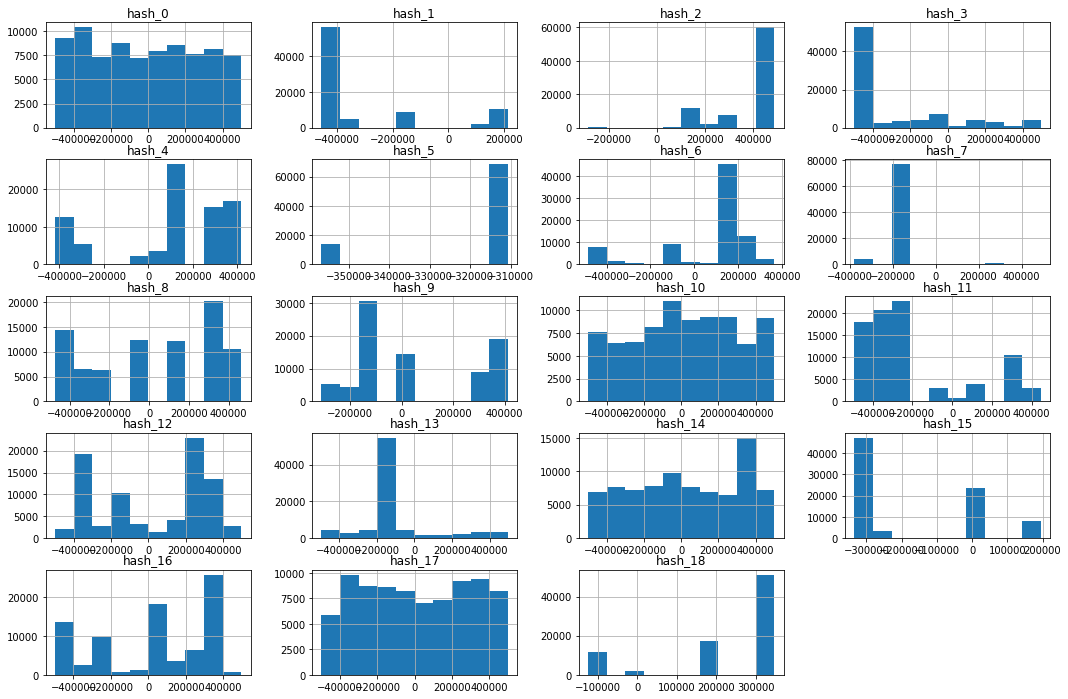

In [17]:
_ = train_data.drop(columns="click").hist(figsize=(18, 12))
plt.show()

From the plots, we can surmize that : -
- hash_5 seems to be a binary label. 
- hash_0, hash_10 and hash_17 seem to categorical variables of high cardinality. 

This can be verified by looking at the distinct values in each column in the dataset. 

In [35]:
for col in train_data.columns:
    if col != "click":
        print(f"Column Name : {col}")
        print(f"Unique Values: {train_data[col].nunique()}")
        print("============")

Column Name : hash_0
Unique Values: 7323
Column Name : hash_1
Unique Values: 9
Column Name : hash_2
Unique Values: 11
Column Name : hash_3
Unique Values: 381
Column Name : hash_4
Unique Values: 10
Column Name : hash_5
Unique Values: 2
Column Name : hash_6
Unique Values: 14
Column Name : hash_7
Unique Values: 12
Column Name : hash_8
Unique Values: 14
Column Name : hash_9
Unique Values: 9
Column Name : hash_10
Unique Values: 3740
Column Name : hash_11
Unique Values: 40
Column Name : hash_12
Unique Values: 1478
Column Name : hash_13
Unique Values: 103
Column Name : hash_14
Unique Values: 34273
Column Name : hash_15
Unique Values: 9
Column Name : hash_16
Unique Values: 470
Column Name : hash_17
Unique Values: 14158
Column Name : hash_18
Unique Values: 5


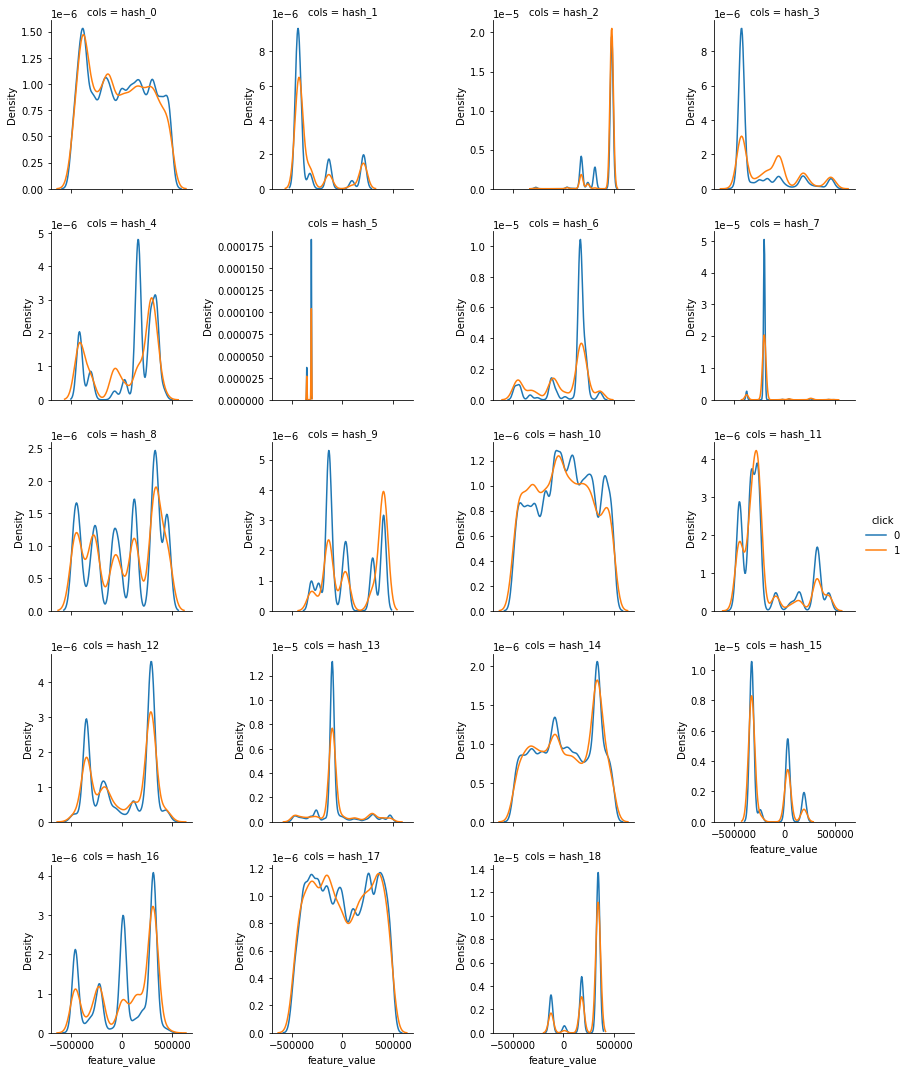

In [34]:
tmp = train_data.melt(["click"], var_name="cols", value_name="feature_value")
g = sns.FacetGrid(tmp, col="cols", hue="click", col_wrap=4, sharey=False)
g = g.map(sns.distplot, "feature_value", hist=False, rug=False)
g.add_legend()


There doesn't seem to be a significant difference in distribution across features for click value **0** and **1** 

# Feature Encoding

Given that all the features in the dataset are categorical, and that some features in the dataset ( hash_0, hash_10, hash_17) have a high cardinality, all the feature columns will undergo the following transformations :- 

- Label Mapping :- To map all the categories between (0 , cardinality of the feature). 
- Target Encoding :- To replace each category in each feature with the mean target value of the **click** column. 

Label / Ordinal Encoding were not used as it is not clear from the dataset if there exists any ordinal relationship between different values of a categorical feature.
One Hot Encoding performs well for features with smaller cardinality, but creates sparse datasets and does not work very well with certain tree based models. 
